# TP 3

### Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en _Material_TPs/TP3/images_ a partir del template _Material_TPs/TP3/template_
#### 1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos


In [89]:
%matplotlib inline  
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('dark_background')


# Comencemos por intentar encontrar ocurrencias únicas dado un patrón y una imagen:
def detect_template(image_path, template_path):
    
    # Cargamos las imagenes en memoria
    template = cv.imread(template_path, cv.IMREAD_GRAYSCALE)
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    
    # Almacenamos sus dimensiones
    w, h = template.shape[::-1]
    iw, ih = image.shape[::-1]


    
    # Detectamos que tanto marco tiene el logo para recortarlo y designificarlo en el patrón
    _, aux = cv.threshold(template, 127, 255, cv.THRESH_BINARY_INV)
    contornos, _ = cv.findContours(aux, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    x, y, cw, ch = cv.boundingRect(np.concatenate(contornos))
    template = template[y:y+ch, x:x+cw]   

    # Usaremos Canny para ser agnósticos del color e intensidad de los logos
    
    
    # Analizamos la intensidad de la imagen para definir umbrales de Canny dinámicamente
    # y previamente hacemos un blur gaussiano para reducir el ruido
    blur = cv.GaussianBlur(image,(11,11), 1)
    th, _ = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    lower = 0.5 * th
    upper = th
    image_edges = cv.Canny(blur, lower, upper, apertureSize = 3)
    
    # Dilatamos la imagen para aumentar la importancia de las líneas
    image_edges = cv.dilate(image_edges,np.ones((3,3), np.uint8), iterations=1)
    
    
    # Definimos un umbral de aceptación (usaremos el método de coeficientes normalizados)
    threshold = 0.21
    
    

    # Deslizaremos el patrón a diferentes escalas para lograr el mejor match posible:
    scales = np.linspace(0.5, 20, 500)

    # En cada iteración, guardaremos los valores del template matching si son
    # los mejores hasta ahora. Inicializamos las variables:
    best_match = threshold
    top_left = [0,0]
    bottom_right = [0,0]
    
    for scale in scales:
        # Si la escala del template supera a la imagen, ya no iteramos en las escalas
        if((w * scale >= iw) or (h * scale >= ih)):
            break

        # Calculamos el template para esta iteración
        resized_template = cv.resize(template,None, fx=scale,fy=scale)
        
        # Obtenemos el Canny del template y lo dilatamos
        template_edges = cv.Canny(resized_template, 200, 250, apertureSize = 3)
        template_edges = cv.dilate(template_edges,np.ones((3,3), np.uint8), iterations=1)
        
        
        # El matching en sí
        res = cv.matchTemplate(image_edges, template_edges, cv.TM_CCOEFF_NORMED)
    
        # Encontramos los valores máximos y mínimos
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

        # Si es el mejor valor, almacenamos el valor y ubicación del match
        if max_val > best_match and max_val!=1:
            best_match = max_val
            rw, rh = template_edges.shape[::-1]
            top_left = max_loc
            bottom_right = (top_left[0] + rw, top_left[1] + rh)
    
    # Leemos la imagen a color para poder graficarla
    image_color = cv.imread(image_path)
    image_color = cv.cvtColor(image,cv.COLOR_BGR2RGB)

    # Si el mejor match supera nuestro umbral, reconocemos el match y lo marcamos con un rectángulo
    if(best_match > threshold):
        cv.rectangle(image_color,top_left, bottom_right, (0,255,0), 7)

    
    # Para terminar, mosramos la imagen (y si se detectó, el matchbox)
    plt.imshow(image_color, 'gray')
    plt.axis('off')
    plt.show()
            

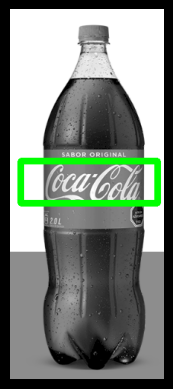

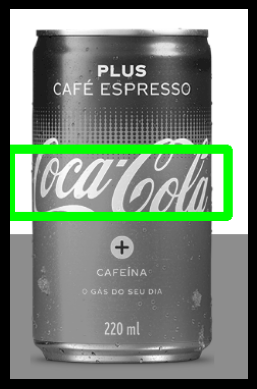

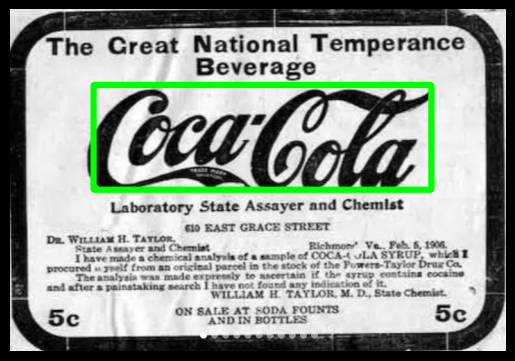

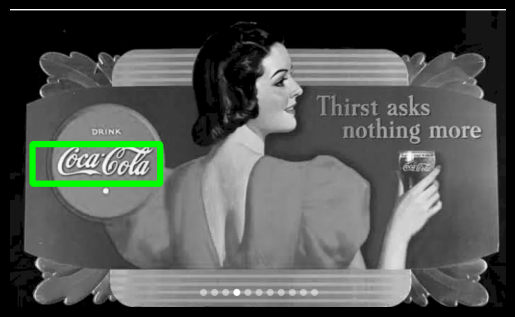

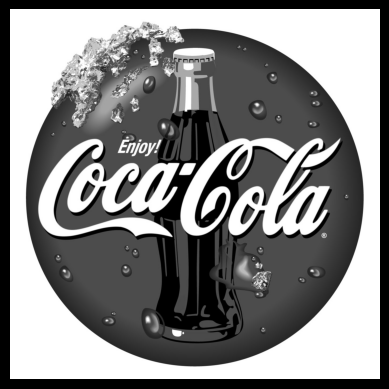

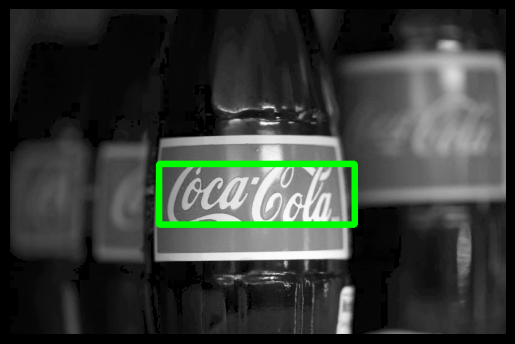

In [90]:
# Probamos el primer método:
 
# Leémos el patrón
logo_path = 'template/pattern.png'

# Guardamos en una variable todas las imágenes con ocurrencia simple:
samples_unique = ['images/coca_logo_1.png',
'images/coca_logo_2.png',
'images/coca_retro_1.png',
'images/coca_retro_2.png',
'images/COCA-COLA-LOGO.jpg',
'images/logo_1.png']

# Invocamos nuestra función para cada imagen:
for path in samples_unique:
    detect_template(path, logo_path)


Puede observarse como no hay falsos positivos y ningún falso negativo.

#### 2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen _coca_multi.png_ con el mismo témplate del ítem 1

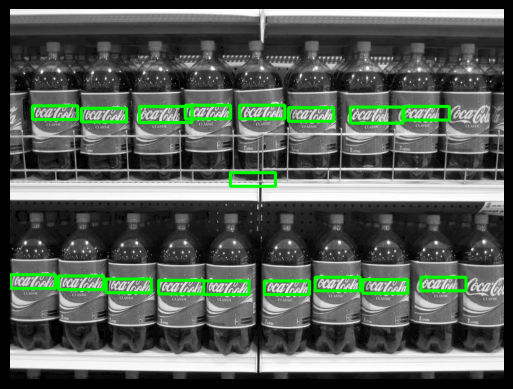

In [91]:
##### Auxiliar #####
def remove_border_percent(img, percent):
    w, h = img.shape[::-1]
    nw = int(w*(1-percent * 2))
    nh = int(h*(1-percent * 2))
    start_x = int(w * percent)
    start_y = int(h * percent)

    result = img[start_y:start_y+nh, start_x:start_x+nw]
    return result



# Copiaremos la función anterior y la adaptaremos a objetos múltiples
def detect_template_multiple(image_path, template_path):
    
    # Cargamos las imagenes en memoria
    template = cv.imread(template_path, cv.IMREAD_GRAYSCALE)
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

    # Realizamos el mismo preprocesado del método anterior:
    _, aux = cv.threshold(template, 127, 255, cv.THRESH_BINARY_INV)
    contornos, _ = cv.findContours(aux, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    x, y, cw, ch = cv.boundingRect(np.concatenate(contornos))
    template = template[y:y+ch, x:x+cw]
    
    # Observando estas imágenes, parece poder mejorarse la detección si
    # nos deshacemos un pequeño porcentaje del margen del logo (no disminuyendo)
    # puntaje si no es visible por superposición)
    template = remove_border_percent(template,0.1)
    

    
    # Pre-procesar con Canny
    image_edges = cv.Canny(image, 100, 450, apertureSize = 3)
    
    # Dilatamos la imagen para aumentar la importancia de las líneas
    image_edges = cv.dilate(image_edges,np.ones((3,3), np.uint8), iterations=1)
    
    # Guardamos las dimensiones para usarlas luego
    w, h = template.shape[::-1]
    iw, ih = image.shape[::-1]
    
    
    # El loop principal del algoritmo consistirá en deslizar el tempalte a distintas escalas
    # como antes, pero ahora guardando todas las ocurrencias que superen el umbral. Luego,
    # nos desharemos de las superposiciones con la implementación de NMS de OpenCV.
    
    boxes = []
    confidences = []
    for scale in np.linspace(0.25, 10, 500):
        # Dejamos de deslizar si el template supera el tamaño de la imagen
        if((w * scale >= iw) or (h * scale >= ih)):
            break
        
        # Escalamos el template y pre-procesamos en la nueva escala
        resized_template = cv.resize(template,None, fx=scale,fy=scale)
        template_edges = cv.Canny(resized_template, 150, 250, apertureSize = 3)
        template_edges = cv.dilate(template_edges,np.ones((3,3), np.uint8), iterations=1)
        
        
        # Obtenemos los resultados de cada posición del template en la iamgen
        res = cv.matchTemplate(image_edges, template_edges, cv.TM_CCOEFF_NORMED)
        
        # Definimos un umbral (bajo debido a Canny dilatado)
        threshold = 0.3
        
        # Nos quedamos sólo con aquellas que superen el umbral
        loc = np.where(res >= threshold)
        # Y las almacenamos en una lista de "cajas"
        for pt in zip(*loc[::-1]):
            boxes.append([pt[0], pt[1], int(w * scale), int(h * scale)])
            confidences.append(res[pt[::-1]])

    # Formateamos las listas para que sean compatibles con el NMS de OpenCV
    boxes = [[x, y, x + w, y + h] for (x, y, w, h) in boxes]
    confidences = [float(c) for c in confidences]
    
    # Aplicamos el NMS y nos devuelve los índices de cajas no superpuestas
    indices = cv.dnn.NMSBoxes(boxes, confidences, score_threshold=threshold, nms_threshold=0.7)
    
    
    # Cargamos en memoria la imagen a color para visualizarla con las detecciones
    image_color = cv.imread(image_path)
    image_color = cv.cvtColor(image,cv.COLOR_BGR2RGB)
    
    # Dibujamos los rectángulos en la imagen usando solo las cajas filtradas por NMS
    for i in indices:
        box = boxes[i]
        startX, startY, endX, endY = box
        cv.rectangle(image_color, (startX, startY), (endX, endY), (0,255,0), 4)
        

    plt.imshow(image_color, 'gray')
    plt.axis('off')
    plt.show()

detect_template_multiple('images/coca_multi.png', logo_path)        

Nótese que los logos no detectados son transfaciones muy alejadas del template (como en las botellas rotadas y en aquellas que solo se ven parcialmente en la imagen).

#### 3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes. Visualizar los resados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.